# The spelled-out intro to neural networks and backpropagation: building micrograd


This is the most step-by-step spelled-out explanation of backpropagation and training of neural networks. It only assumes basic knowledge of Python and a vague recollection of calculus from high school.

[Original Video](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4868s)

> Note that these are my notes and organized thoughts after watching the video. Original credit goes to Karpathy. He goes through all the content in much greater detail than I can cover in these notes. Man is outright amazing.

## Calculating The Gradient

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

We can calculate the gradient at any point in x by taking $\frac{f(x+h) - f(x)}{h}$ for some very very very small value of h

In [3]:
def replace_trailing_zeros_with_spaces(s):
    return s.rstrip('0').ljust(len(s))

In [4]:
hs = [0.1,0.001,0.0001,0.00001,0.000001]

x = 2
precision = 10

for h in hs:
    h_formatted = replace_trailing_zeros_with_spaces(format(h, f".{precision}f"))
    result = replace_trailing_zeros_with_spaces(format((f(x+h) - f(x))/h, f".{precision}f"))
    print(f"{h_formatted}: {result}")

0.1         : 8.3         
0.001       : 8.003       
0.0001      : 8.0003      
0.00001     : 8.0000300001
0.000001    : 8.0000030014


We can see that as we decrease the value of h, the gradient becomes an ever increasingly accurate approximation. We can verify that this is the right gradient by performing a symbolic gradient calculation

6x -4 => 6(2)-4 = 8

## Multiple Unknowns


So far we've seen how to calculate the gradient for a equation with a single variable. Well, how about one with multiple variables?

In [5]:
a = 2
b = -3
c = 10
d = a * b + c
print(d)

4


What happens if we increase a by just a small amount (Eg. h)

In [6]:
h = 0.000001


a = 2
b = -3
c = 10
a+=h
d = a * b + c
print(d)

3.9999969999999996


In short, we change the value of a single variable in the equation by a small number, calculate the result of the final variable while __keeping all other values constant__. 

In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Value Object


Eventually we'll be working with networks that have thousands of these variables and so we need a data structure that mantain both the value and the relationship between these variables.


We will be using a value object to represent individual numbers. These value objects will then be arranged in a DAG ( Directed Acylic Graph ) in order to calculate their gradients

## Creating and Visualising Value

Let's now put together a small code segment to visualise the relationship between values

In [8]:
class Value:
    def __init__(self,data:int):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"

Value(3)

Value(data=3)

We can then implement simple addition and multiplication using these values by providing our own implementations of the `__add__` and `__mul__` function.

We also add in two new properties

1. `_op` :  track how a value was produced
2. `_prev` : track the children of a specific node (Eg. if 7 was produced by two nodes that had values of 3 and 4)


In [9]:
class Value:
    def __init__(self,data:int,_prev = (),_op=""):
        self.data = data
        self._op = _op
        self._prev = _prev
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other:Value):
        return Value(self.data+other.data,(self,other),"+")
    
    def __mul__(self,other:Value):
        return Value(self.data*other.data,(self,other),"*")

print(f"When we take 3 * 4 => {Value(3)*Value(4)}")
print(f"When we take 2 + 4 => {Value(2)+Value(4)}")

When we take 3 * 4 => Value(data=12)
When we take 2 + 4 => Value(data=6)


Now that we've implemented simple addition and subtraction, let's implement a function to visualize the combination of a few values

In [10]:
a = Value(3)
b = Value(4)
c = a + b
print(c)

Value(data=7)


In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{data %.4f}" % (n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

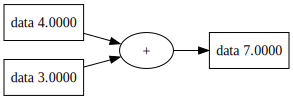

In [13]:
draw_dot(c)

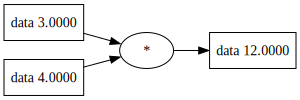

In [14]:
a = Value(3)
b = Value(4)
c = a * b
draw_dot(c)

# Calculating Gradients

Now that we've got an easy way to visualise each individual set of nodes in a graph, we can move on to calculating the gradients.

We begin by introducing two more properties

- `grad` : This represents the gradient and update our graphviz function to display the `grad` property
- `label` : This is a label that can be used to identify a node

In [25]:
class Value:
    def __init__(self,data:int,_prev = (),_op="",label = ""):
        self.data = data
        self._op = _op
        self._prev = set(_prev)
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other:Value):
        return Value(self.data+other.data,(self,other),"+")
    
    def __mul__(self,other:Value):
        return Value(self.data*other.data,(self,other),"*")

print(f"When we take 3 * 4 => {Value(3)*Value(4)}")
print(f"When we take 2 + 4 => {Value(2)+Value(4)}")

When we take 3 * 4 => Value(data=12)
When we take 2 + 4 => Value(data=6)


In [21]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

We can in turn run this new update function to get the following representation

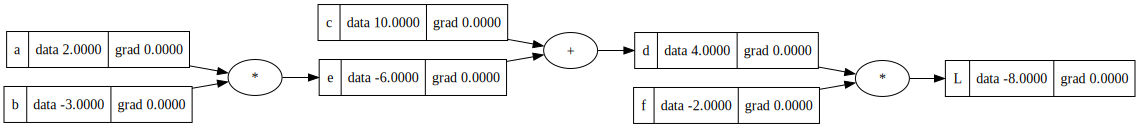

In [26]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dot(L)

## Single Equation

### Addition

Let's move on to calcuating gradients. Ideally we'd like to find the value of the final output w.r.t each variable

For an equation $L = d + f$ where we wish to find the value $\frac{dL}{df}$, $\frac{dL}{dd}$ and $\frac{dL}{dL}$.
 
-  $\frac{dL}{dL}$ is always going to be 1

Let's calculate it and see what we get 


In [36]:
h = 0.00001

def derivative_of_l_with_respect_to_f():
    d = Value(4)
    # Adding the h here
    f = Value(2)
    L = d + f; 
    
    d = Value(4)
    # Adding the h here
    f = Value(2+h)
    L2 = d + f; 
    
    print("The derivative of L with respect to F is going to be ",(L2.data-L.data)/h)
    

def derivative_of_l_with_respect_to_d():
    d = Value(4)
    # Adding the h here
    f = Value(2)
    L = d + f; 
    
    d = Value(4+h)
    # Adding the h here
    f = Value(2)
    L2 = d + f; 
     
    
    print("The derivative of L with respect to d is going to be ",(L2.data-L.data)/h)
    

derivative_of_l_with_respect_to_f()    
derivative_of_l_with_respect_to_d() 

The derivative of L with respect to F is going to be  0.9999999999621422
The derivative of L with respect to d is going to be  0.9999999999621422


### Multiplication

Let's move on to calcuating gradients. Ideally we'd like to find the value of the final output w.r.t each variable

For an equation $L = d * f$ where we wish to find the value $\frac{dL}{df}$, $\frac{dL}{dd}$ and $\frac{dL}{dL}$.
 
-  $\frac{dL}{dL}$ is always going to be 1

Let's calculate it and see what we get 


In [37]:
h = 0.00001

def derivative_of_l_with_respect_to_f():
    d = Value(4)
    f = Value(2)
    L = d * f; 
    
    d = Value(4)
    # Adding the h here
    f = Value(2+h)
    L2 = d * f; 
    
    print("The derivative of L with respect to F is going to be ",(L2.data-L.data)/h)
    

def derivative_of_l_with_respect_to_d():
    d = Value(4)
    f = Value(2)
    L = d * f; 
    
    d = Value(4+h)
    # Adding the h here
    f = Value(2)
    L2 = d * f; 
    
    
    print("The derivative of L with respect to d is going to be ",(L2.data-L.data)/h)
    

derivative_of_l_with_respect_to_f()    
derivative_of_l_with_respect_to_d() 

The derivative of L with respect to F is going to be  4.000000000026205
The derivative of L with respect to d is going to be  1.9999999999242843


## Neural Network 

In order to extend our application to neural networks, we need to add in a TanH function, which is used to force the output to a value of -1 to 1.

### Implementing Tanh

Here is a plot of TanH below.

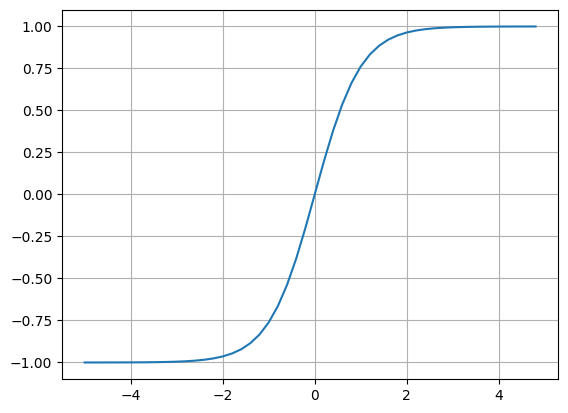

In [44]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Let's now construct a more complicated version using the `Value` class which implements tanh. Note that we need to implement a tanh function because it is a hyperbolic function and cannot be constructed from a simple plus and mul operation

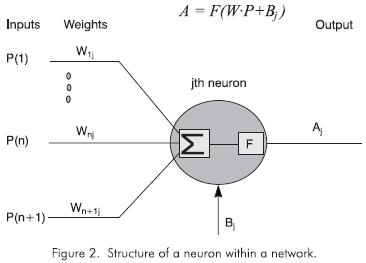

In [47]:
from IPython import display
display.Image("https://i.stack.imgur.com/rmYf1.jpg")

In [54]:
class Value:
    def __init__(self,data:int,_prev = (),_op="",label = ""):
        self.data = data
        self._op = _op
        self._prev = set(_prev)
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other:Value):
        return Value(self.data+other.data,(self,other),"+")
    
    def __mul__(self,other:Value):
        return Value(self.data*other.data,(self,other),"*")
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        return out
        

In [55]:
# Value of X
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

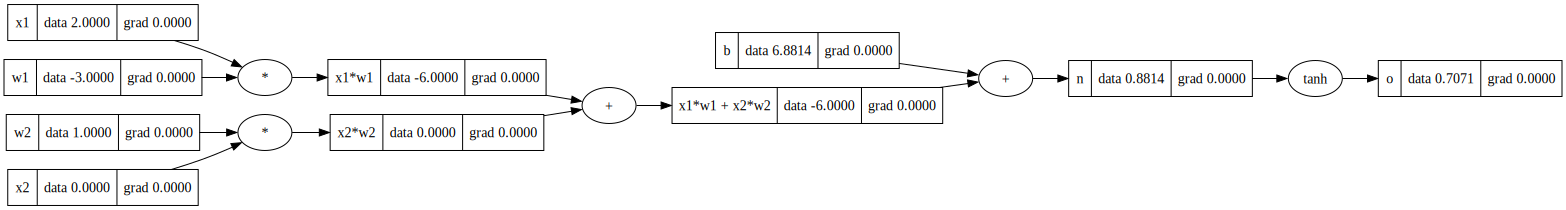

In [56]:
draw_dot(o)

We can then implement a differentiated form of tanh by applying the formula of

$$
o = tanh(n) \\
\frac{dO}{dn} = 1 - o^2
$$

In [58]:
1 - o.data**2

0.4999999999999999

Therefore the gradient is ~0.5

### Takeaway

Therefore we can see that there are two main cases


| Original Equation  | $$\frac{da}{da}$$ | $$\frac{db}{da}$$ | $$\frac{dc}{da}$$ |
| :---------------   | :---------------: | :---------------: | :---------------: |
| a = b + c          | 1                 | 1                 | 1                 |
| a = b * c          | 1                 | c                 | b                 | 
| a = tanh(b)        | 1                 | 1-$a^2$             | nil               | 



## Chain Rule and more complex equations

Let's start looking at more complex equations which involve multiple Value objects. This is likely to be the case when working with larger neural networks


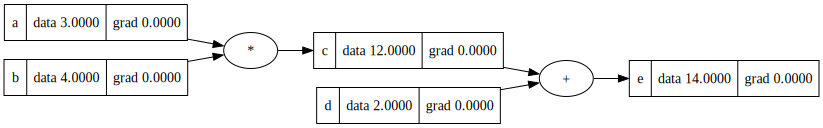

In [39]:
a = Value(3,label = "a")
b = Value(4,label = "b")
c = a * b
c.label = "c"
d = Value(2,label = "d")
e = c + d
e.label = "e"
draw_dot(e)

If we wanted to find $\frac{de}{da}$, then this is simply $\frac{de}{dc}\times\frac{dc}{da}$. We already learned how to do this in the previous section

1. $\frac{de}{dc}$ - We know that this will be 1
2. $\frac{dc}{da}$ - We know that this will be the value of b, which will be $a$

Therefore this will be a node with the gradient of 4

In [42]:
h = 0.00001

def derivative_of_e_with_respect_to_a():
    a = Value(3,label = "a")
    b = Value(4,label = "b")
    c = a * b
    c.label = "c"
    d = Value(2,label = "d")
    e = c + d
    
    a = Value(3 + h,label = "a")
    b = Value(4,label = "b")
    c = a * b
    c.label = "c"
    d = Value(2,label = "d")
    e2 = c + d
    
    print("The derivative of E with respect to A is going to be ",(e2.data-e.data)/h)
    
derivative_of_e_with_respect_to_a()

The derivative of E with respect to A is going to be  4.000000000026205


# Automating Gradient Calculation

Now that we know how to implement Back Propogation for each individual operation ( + or * ), we can implement a function which implements it.

## Single Step Calculation

Let's start by implementing a back propogation that operates on a single node and its children. We know that we have three base cases

1. The current node is a leaf node and has no children, therefore do nothing.
2. The current node has two children and was formed by an addition step, therefore set children's gradient to be the gradient of the current node 
3. The current node has two children and was formed by an multiplication step, therefore set children's gradient to be the gradient of the current node * the value of the other child

If it's a bit confusing, let's see how it's implemented in code. We'll indicate the action to be take using a new property - `_backward`

In [57]:
class Value:
    def __init__(self,data:int,_prev = (),_op="",label = ""):
        self.data = data
        self._op = _op
        self._prev = set(_prev)
        self.grad = 0.0
        self.label = label
        self._backward = lambda : None
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other:Value):
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
          self.grad = out.grad
          other.grad = out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self,other:Value):
        out = Value(self.data*other.data,(self,other),"*")
        def _backward():
          self.grad = other.data * out.grad
          other.grad = self.data * out.grad
            
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        
        def _backward():
          self.grad = 1 - t**2
        
        out = Value(t, (self, ), 'tanh')
        out._backward = _backward
        
        return out


Let's test it out on a few different examples

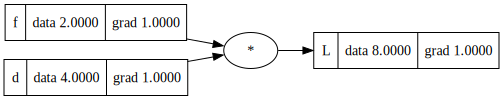

In [64]:
d = Value(4,label = "d")
# Adding the h here
f = Value(2,label = "f")
L = d + f; 
L.grad=1
L._backward()
L.label = "L"
draw_dot(L)

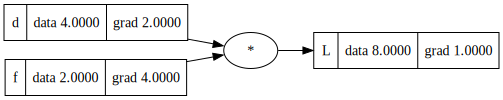

In [65]:
d = Value(4,label = "d")
# Adding the h here
f = Value(2,label = "f")
L = d * f; 
L.grad=1
L._backward()
L.label = "L"
draw_dot(L)

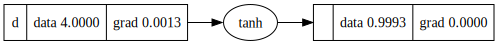

In [67]:
d = Value(4,label="d")
e = d.tanh()
e._backward()
draw_dot(e)

## Recursive back Propogation

We now need to implement a back propogation algorithm that works recursively onto the DAG. However, since the parent value will affect the value of the child, we need to make sure to call `._backward()` on the parents before we move on to the child nodes

We can do this using a topological sort

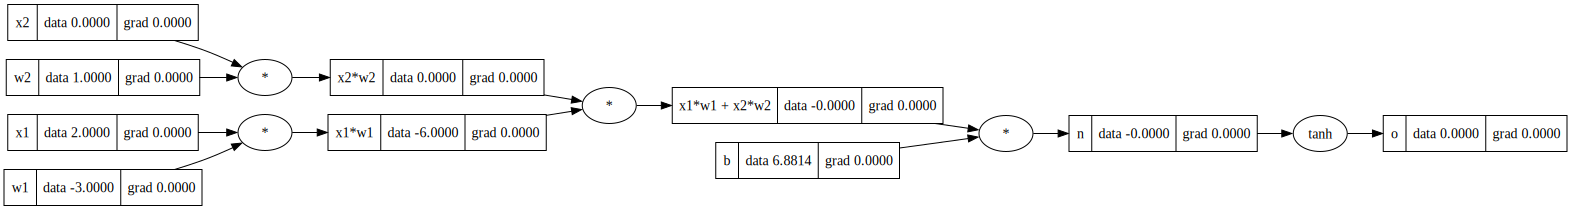

In [68]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

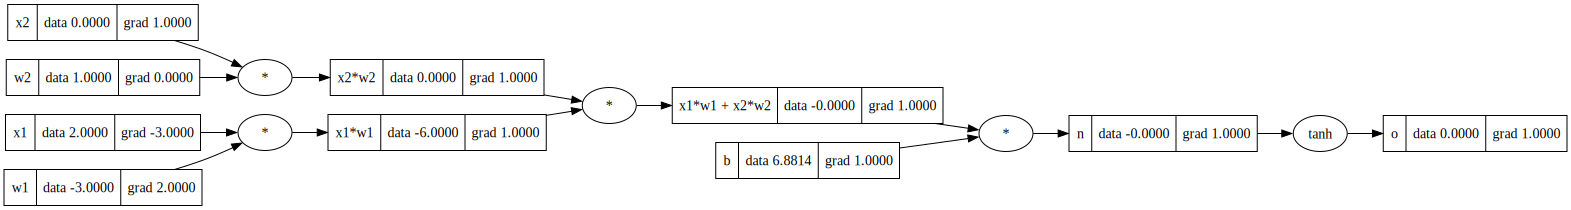

In [70]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

o.grad = 1.0
for node in reversed(topo):
  node._backward()

draw_dot(o)

We can add this to our Value definition as seen below to define a recursive implementation of `backward`

In [71]:
class Value:
    def __init__(self,data:int,_prev = (),_op="",label = ""):
        self.data = data
        self._op = _op
        self._prev = set(_prev)
        self.grad = 0.0
        self.label = label
        self._backward = lambda : None
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other:Value):
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
          self.grad = out.grad
          other.grad = out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self,other:Value):
        out = Value(self.data*other.data,(self,other),"*")
        def _backward():
          self.grad = other.data * out.grad
          other.grad = self.data * out.grad
            
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        
        def _backward():
          self.grad = 1 - t**2
        
        out = Value(t, (self, ), 'tanh')
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

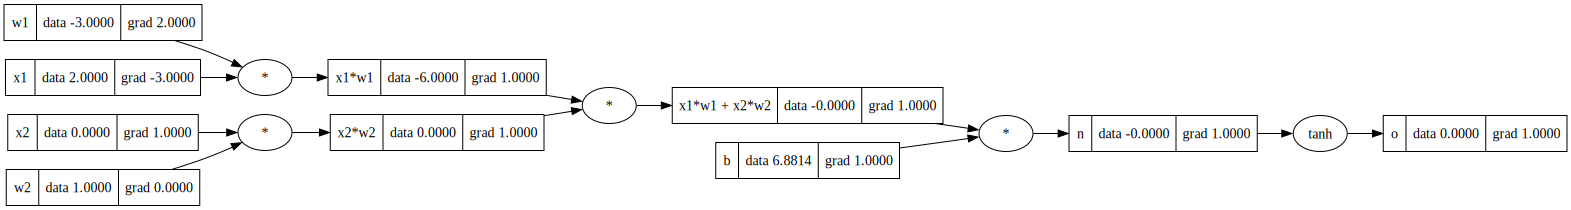

In [72]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

draw_dot(o)

However, if we look at the following equations, we realise that we have a slight error in our calculations when we are re-using a variable more than once

In this example, a's gradient should be 2 instead of 1

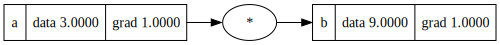

In [73]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

The gradients of a and b are wrong in this example. This is because we are overwriting the value of the gradients if we encounter a shared variable twice.

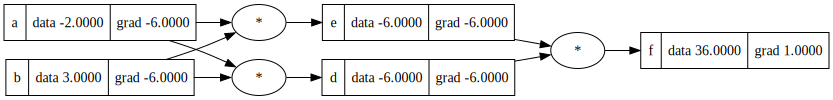

In [74]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

Therefore we need to change our `__add__`, `__mul__` and `tanh` to use a `+=` instead of `=` operator to account for this edge case. In other words, we accumulate our gradients.

In [75]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

Let's see our original example and break it down for each individual component

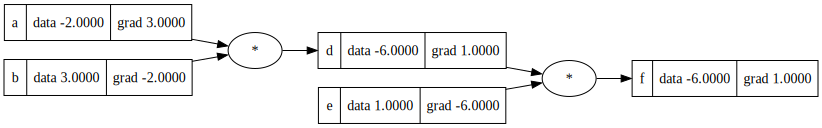

In [85]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = Value(1)    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)



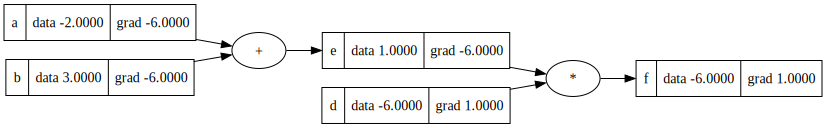

In [84]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = Value(-6)    ; d.label = 'd'
e = a+b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)



Therefore when we combine the two, we should get the following gradients

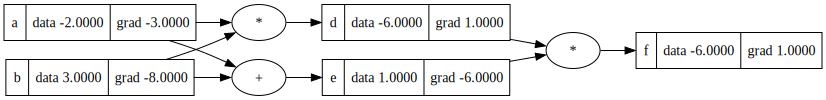

In [86]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

The same goes for our addition which now has the right gradients

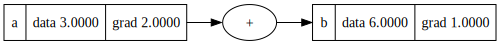

In [77]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

# Touching Up

Now we try to add make our expression a lil nicer

Notice that if we try to perform the following operations we get errors

In [87]:
Value(3) + 2

AttributeError: 'int' object has no attribute 'data'

In [88]:
Value(3)*2

AttributeError: 'int' object has no attribute 'data'

We can solve this by implementing a quick guard in our `_add__` and `__mul__` functions and implementing a `rmul` implementation